In [68]:
import pandas as pd 
import pingouin as pg
import plotly.express as px
import plotly.figure_factory as ff 
import matplotlib.pyplot as plt 

# Machine Learning
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import optuna

In [69]:
# Carregar DF
df_transacoes = pd.read_csv(r'.\datasets\transacoes_fraude.csv')

In [70]:
df_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cliente                     13000 non-null  object 
 1   Tipo de Transacao           13000 non-null  object 
 2   Valor da Transacao          13000 non-null  float64
 3   Valor Anterior a Transacao  13000 non-null  float64
 4   Valor Apos a Transacao      13000 non-null  float64
 5   Horario da Transacao        13000 non-null  object 
 6   Classe                      13000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 711.1+ KB


In [71]:
df_transacoes.head(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe
0,cliente1D4F0B,Saque,390.39,5446.75,5056.36,2023-03-14T07:29:28.256579,0
1,clienteCF3D89,Saque,3272.03,12167.89,8895.86,2023-02-12T17:54:09.119410,0
2,cliente0F0D32,PIX,4905.72,8217.63,3311.91,2023-10-03T17:31:42.087599,0
3,clienteFCC0EA,PIX,3073.23,7833.16,4759.93,2024-05-23T17:57:02.055680,0
4,cliente9BA227,PIX,4233.03,6920.82,2687.79,2022-10-07T17:30:36.879557,0
5,cliente62C357,Débito,4848.49,7354.41,2505.92,2025-07-08T19:16:37.207970,0
6,cliente320C76,Crédito,1600.44,7296.87,5696.43,2024-09-07T02:23:16.975044,0
7,cliente32CB58,Crédito,1296.71,10562.92,9266.21,2023-08-28T23:09:19.817457,0
8,cliente67AFD9,Débito,1187.35,10935.18,9747.83,2024-05-21T09:01:08.163132,0
9,cliente84F77D,PIX,3271.51,3405.61,134.10,2022-09-26T10:33:12.415982,0


In [72]:
df_transacoes.tail(10)

,Cliente,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Horario da Transacao,Classe
12990,clienteD394F2,Saque,1773.96,7228.48,5454.52,2025-05-27T23:04:38.515784,0
12991,clienteB400AC,Crédito,1301.17,5726.47,4425.30,2022-07-02T21:01:21.284832,0
12992,cliente818A20,PIX,316.26,7039.47,6723.21,2023-11-06T10:53:36.498771,0
12993,cliente2A37C1,Saque,942.85,5177.53,4234.68,2024-11-29T05:56:55.666167,0
12994,clienteDA95A6,Débito,585.15,2959.63,2374.48,2023-02-19T10:36:17.219524,0
12995,clienteF61967,Saque,1526.11,9680.53,8154.42,2025-04-25T18:48:03.335688,0
12996,cliente51CF5C,PIX,888.23,6677.31,5789.08,2024-10-13T19:31:11.093681,0
12997,cliente0D3251,Saque,4245.13,4926.23,681.10,2023-02-17T22:45:31.584409,0
12998,clienteAFCFB7,Saque,3880.87,7778.95,3898.08,2024-02-10T18:56:08.194584,0
12999,cliente84748D,PIX,3690.41,12992.52,9302.11,2022-11-07T13:29:42.965114,0


### Ajustando Data Frame

In [73]:
df_transacoes.drop(columns=['Cliente'], axis=1, inplace = True)

In [74]:
df_transacoes['Horario da Transacao'] = pd.to_datetime(df_transacoes['Horario da Transacao'])

In [75]:
def periodo_transation(h):
    r = ''
    if 0 <= h < 6: r = 'Madrugada'
    elif 6 <= h < 12: r = 'Manhã'
    elif 12 <= h < 18: r = 'Tarde'
    else: r = 'Noite'
    return r
 
df_transacoes['Periodo da Transacao'] = df_transacoes['Horario da Transacao'].dt.hour.apply(periodo_transation)

In [76]:
df_transacoes.drop(columns=['Horario da Transacao'], axis =1, inplace = True)

In [77]:
df_transacoes.head(10)

,Tipo de Transacao,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Classe,Periodo da Transacao
0,Saque,390.39,5446.75,5056.36,0,Manhã
1,Saque,3272.03,12167.89,8895.86,0,Tarde
2,PIX,4905.72,8217.63,3311.91,0,Tarde
3,PIX,3073.23,7833.16,4759.93,0,Tarde
4,PIX,4233.03,6920.82,2687.79,0,Tarde
5,Débito,4848.49,7354.41,2505.92,0,Noite
6,Crédito,1600.44,7296.87,5696.43,0,Madrugada
7,Crédito,1296.71,10562.92,9266.21,0,Noite
8,Débito,1187.35,10935.18,9747.83,0,Manhã
9,PIX,3271.51,3405.61,134.10,0,Manhã


In [78]:
df_transacoes.isna().sum()

Tipo de Transacao             0
Valor da Transacao            0
Valor Anterior a Transacao    0
Valor Apos a Transacao        0
Classe                        0
Periodo da Transacao          0
dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x23ef134ac10>,
 'caps': [<matplotlib.lines.Line2D at 0x23ef1358050>,
 'boxes': [<matplotlib.lines.Line2D at 0x23ef134a350>],
 'medians': [<matplotlib.lines.Line2D at 0x23ef133f250>],
 'fliers': [<matplotlib.lines.Line2D at 0x23ef1359bd0>],
 'means': []}

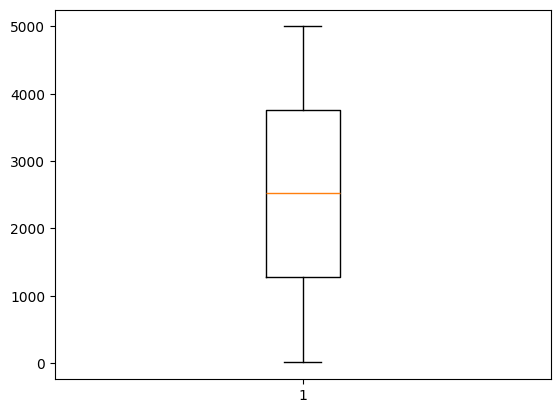

In [79]:
plt.boxplot(x=df_transacoes['Valor da Transacao'])

{'whiskers': [<matplotlib.lines.Line2D at 0x23ef139e250>,
 'caps': [<matplotlib.lines.Line2D at 0x23ef139f5d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x23ef139d790>],
 'medians': [<matplotlib.lines.Line2D at 0x23ef13aca10>],
 'fliers': [<matplotlib.lines.Line2D at 0x23ef13ad350>],
 'means': []}

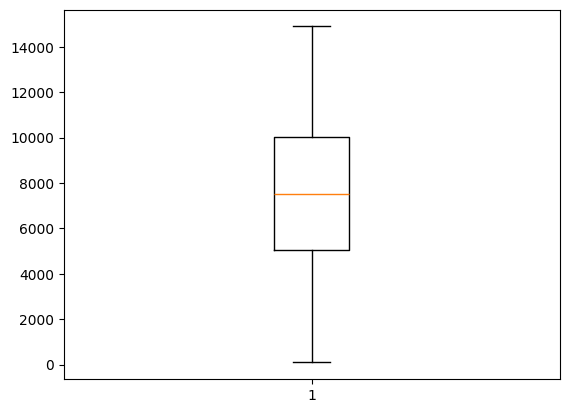

In [80]:
plt.boxplot(x=df_transacoes['Valor Anterior a Transacao'])

{'whiskers': [<matplotlib.lines.Line2D at 0x23ef1414510>,
 'caps': [<matplotlib.lines.Line2D at 0x23ef1414e90>,
 'boxes': [<matplotlib.lines.Line2D at 0x23ef1407c50>],
 'medians': [<matplotlib.lines.Line2D at 0x23ef14160d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x23ef14169d0>],
 'means': []}

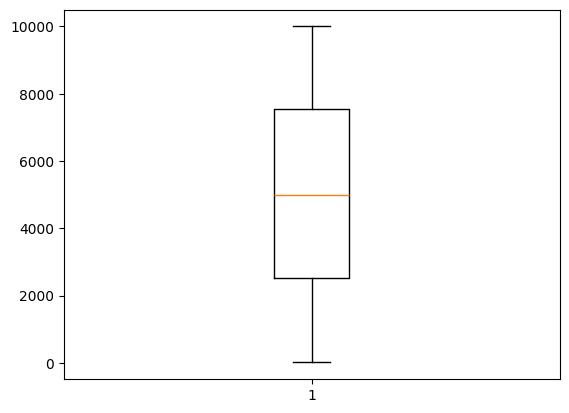

In [81]:
plt.boxplot(x=df_transacoes['Valor Apos a Transacao'])

In [82]:
df_transacoes.describe()

,Valor da Transacao,Valor Anterior a Transacao,Valor Apos a Transacao,Classe
count,13000.000000,13000.000000,13000.000000,13000.000000
mean,2511.899952,7547.003386,5035.103435,0.110000
std,1436.446865,3225.212074,2884.967560,0.312902
min,10.000000,95.440000,10.120000,0.000000
25%,1279.412500,5038.805000,2533.727500,0.000000
50%,2525.610000,7538.255000,4997.090000,0.000000
75%,3754.945000,10046.875000,7551.552500,0.000000
max,4999.960000,14897.740000,9999.390000,1.000000


In [83]:
df_transacoes['Periodo da Transacao'].value_counts(normalize=True) * 100

Periodo da Transacao
Madrugada    27.407692
Noite        24.476923
Manhã        24.323077
Tarde        23.792308
Name: proportion, dtype: float64

In [84]:
df_transacoes['Classe'].value_counts(normalize=True) * 100

Classe
0    89.0
1    11.0
Name: proportion, dtype: float64

### Treinando modelo

In [85]:
X = df_transacoes.drop(columns=['Classe'], axis=1)
y = df_transacoes.Classe

In [86]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

colunas_numericas = ['Valor da Transacao', 'Valor Anterior a Transacao', 'Valor Apos a Transacao']
colunas_categoricas = ['Tipo de Transacao', 'Periodo da Transacao']

numerico_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorico_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerico_transformer, colunas_numericas),
    ('cat', categorico_transformer, colunas_categoricas)
])

# Classificador com balanceamento
classifier = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=5,       # limitar profundidade
    min_samples_leaf=20, # cada folha precisa ter pelo menos 20 amostras
    random_state=51
)

smote = SMOTE(random_state=51)

model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', classifier)
])


In [87]:
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
metrics_result = cross_validate(model, X, y, cv=cv_folds, scoring=['accuracy'], return_estimator=True)


In [88]:
metrics_result['test_accuracy'].mean()


np.float64(0.6130769230769231)

In [89]:

y_pred = cross_val_predict(model, X, y, cv=cv_folds)
classification_report_str = classification_report(y, y_pred)
print(f"Relatorio de Classificação: \n{classification_report_str}")


Relatorio de Classificação: 
              precision    recall  f1-score   support

           0       0.91      0.63      0.74     11570
           1       0.14      0.51      0.22      1430

    accuracy                           0.61     13000
   macro avg       0.53      0.57      0.48     13000
weighted avg       0.83      0.61      0.69     13000



Tive que utilizar SMOTE e alterar meu classificador no meu pipeline, pois, ao realizar como foi feito em aula, obtive uma acurácia boa de 0,80. Porém, essa acurácia era praticamente da classe majoritária e não da minoritária, a qual possuía um recall de 0,11. Com essas alterações, alcancei um recall de 0,51 na classe minoritária, porém houve um aumento na quantidade de falsos positivos, uma vez que a acurácia caiu para 0,61.

In [90]:
def decisiontree_optuna(trial):
    
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1,20)
    max_depth = trial.suggest_int('max_depth', 1,10)
    model.set_params(classifier__min_samples_leaf=min_samples_leaf)
    model.set_params(classifier__max_depth=max_depth)
    model.set_params(classifier__class_weight='balanced')
    
    scores = cross_val_score(model, X, y, cv=cv_folds, scoring='recall')
    
    return scores.mean()


In [91]:
estudo_decisiontree = optuna.create_study(direction='maximize')
estudo_decisiontree.optimize(decisiontree_optuna, n_trials=300)


[I 2025-10-17 12:53:47,773] A new study created in memory with name: no-name-8810aa1b-1324-4651-a634-7134c0a99218
[I 2025-10-17 12:53:48,545] Trial 0 finished with value: 0.5041958041958041 and parameters: {'min_samples_leaf': 15, 'max_depth': 7}. Best is trial 0 with value: 0.5041958041958041.
[I 2025-10-17 12:53:49,114] Trial 1 finished with value: 0.5083916083916085 and parameters: {'min_samples_leaf': 7, 'max_depth': 5}. Best is trial 1 with value: 0.5083916083916085.
[I 2025-10-17 12:53:49,925] Trial 2 finished with value: 0.48041958041958044 and parameters: {'min_samples_leaf': 3, 'max_depth': 10}. Best is trial 1 with value: 0.5083916083916085.
[I 2025-10-17 12:53:50,252] Trial 3 finished with value: 0.4244755244755245 and parameters: {'min_samples_leaf': 9, 'max_depth': 1}. Best is trial 1 with value: 0.5083916083916085.
[I 2025-10-17 12:53:50,905] Trial 4 finished with value: 0.4951048951048951 and parameters: {'min_samples_leaf': 13, 'max_depth': 6}. Best is trial 1 with valu

In [94]:
print(f"Melhor Recall: {estudo_decisiontree.best_value} \nMelhores parâmetros: {estudo_decisiontree.best_params}")


Melhor Recall: 0.5328671328671328 
Melhores parâmetros: {'min_samples_leaf': 6, 'max_depth': 4}


Ao ajustar os hiperparâmetros para focar no recall da classe minoritária, obtive que a árvore com altura 4 e quantidade mínima de 6 folhas obteve um recall maior de 0,53

In [101]:
X_train_tree = X_train.copy()
X_train_tree['Tipo_Transacao'] = X_train_tree['Tipo de Transacao'].astype('category').cat.codes
X_train_tree['Periodo_Transacao'] = X_train_tree['Periodo da Transacao'].astype('category').cat.codes
X_train_tree = X_train_tree.drop(columns=['Tipo de Transacao', 'Periodo da Transacao'], errors='ignore')


In [ ]:

preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', ['Valor da Transacao', 'Valor Anterior a Transacao', 'Valor Apos a Transacao']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Tipo de Transacao', 'Periodo da Transacao'])
])

clf = DecisionTreeClassifier(
    min_samples_leaf=estudo_decisiontree.best_params['min_samples_leaf'],
    max_depth=estudo_decisiontree.best_params['max_depth'],
    class_weight='balanced',
    random_state=51
)

model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=51)),
    ('classifier', clf)
])

model.fit(X, y) 


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


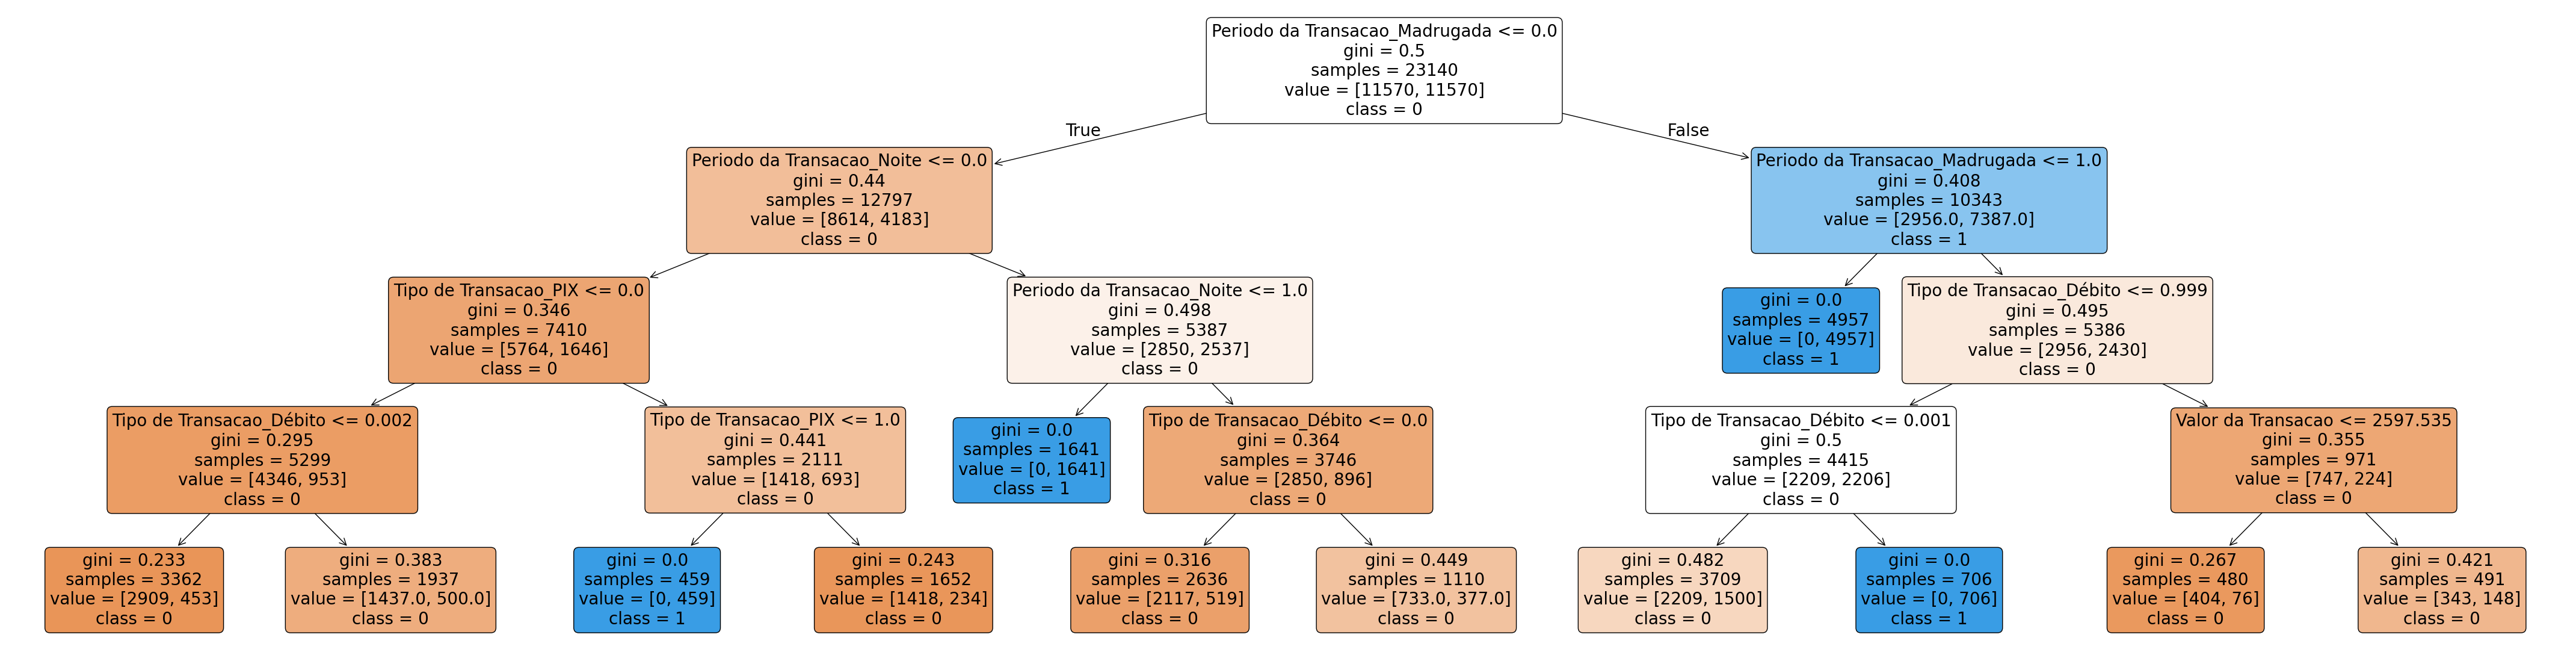

In [118]:
# Features numéricas
num_features = ['Valor da Transacao', 'Valor Anterior a Transacao', 'Valor Apos a Transacao']

# Features categóricas após OneHotEncoder
cat_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(colunas_categoricas))

# Todas as features juntas
feature_names = num_features + cat_features


plt.figure(figsize=(55, 14))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=['0', '1'],
    filled=True,
    rounded=True,
    fontsize=20
)
plt.show()

Temos dados extremamente desbalanceados e, caso fosse realizado um treinamento comum, a árvore tenderia a favorecer a classe majoritária. Para resolver isso, implementei alterações utilizando SMOTE. Com essa técnica, consegui acertar mais da metade dos casos positivos da classe minoritária e obter uma melhor predição dos dados. Tentei realizar um ajuste de hiperparâmetros com foco no recall da classe minoritária e obtive um resultado próximo (0,53) ao já encontrado anteriormente (0,51). Concluo que, para este DataFrame, a árvore de decisão não foi a melhor escolha, pois não lida bem com dados extremamente desbalanceados. Além disso, ao tentar equilibrar esses dados, houve um aumento nos falsos positivos, o que, nessa situação, prejudicaria a experiência do cliente